In [2]:
import torch.nn as nn 
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\Antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
words=open("names.txt").read().splitlines()

In [4]:
chars=sorted(list(set("".join(words))))
stoi={s: i+1 for i,s in enumerate(chars)}
stoi['.']=0


itos={i:s for s,i in stoi.items()}
encode= lambda s : [stoi[c] for c in s] #-->int
decode=lambda i :  "".join([itos[x] for x in i  ])




In [5]:

block_size=3
def build_dataset(words) :
    X,Y=[],[]

    for w in words:
        context=[0] * block_size
        for ch in w+ '.' :
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join([itos[i] for i in context])," gives ","".join(itos[ix]))
            context=context[1:]+ [ix]

    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape)
    return X,Y

import random 
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])

torch.Size([182625, 3])
torch.Size([22655, 3])
torch.Size([22866, 3])


In [6]:
len(chars)

26

In [7]:
g=torch.Generator().manual_seed(2147483647)

vocab_size=27
n_emb=10
hidden_layer=n_hidden=200

C=torch.randn((vocab_size,n_emb))
W1=torch.randn((n_emb*block_size,hidden_layer),generator=g) * (5/3)/((n_emb*block_size)**0.5)#*0.2
b1=torch.randn(hidden_layer,generator=g)*0.01
W2=torch.randn((hidden_layer,vocab_size),generator=g)*0.01
b2=torch.randn(vocab_size,generator=g)*0

bngain=torch.ones(1,n_hidden)
bnbias=torch.zeros(1,n_hidden)
bnmean_running=torch.zeros(1,n_hidden)
bnstd_running=torch.ones(1,n_hidden)
parameters=[C,W1,b1,W2,b2,bngain,bnbias]

for p in parameters:
    p.requires_grad=True


In [8]:
lri=[]
lossi=[]
stepi=[]



In [9]:
batch_size=32
max_steps=30000


for i in range(max_steps) :

    #mini batch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g )

    Xb,Yb=Xtr[ix],Ytr[ix]

    emb=C[Xb]
    H,W,CH=emb.shape

    #forward pass
    embcat=emb.view(H,W*CH)
    hpreact=embcat@W1 + b1
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)

    with torch.no_grad() :
        bnmean_running=0.999*bnmean_running+0.001*bnmeani
        bnstd_running=0.999*bnstd_running+0.001*bnstdi

    
    hpreact=bngain*((hpreact-bnmeani)/bnstdi) + bnbias
    h=torch.tanh(hpreact) ##broadcasting
    logits=h@W2 +b2
    loss=F.cross_entropy(logits,Yb)
    for p in parameters :
        p.grad=None
    loss.backward()

    ##update

    # lr=lrs[i]
    lr=0.1 if i< 10000 else  0.01
    for p in parameters :
        p.data+=-lr*p.grad
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    print(f"{i:7d}/{max_steps:7d} : {loss.item():4f}")
    

      0/  30000 : 3.284967
      1/  30000 : 3.277417
      2/  30000 : 3.341810
      3/  30000 : 3.165682
      4/  30000 : 3.177664
      5/  30000 : 3.137350
      6/  30000 : 3.156842
      7/  30000 : 3.072277
      8/  30000 : 3.074012
      9/  30000 : 2.932142
     10/  30000 : 3.016037
     11/  30000 : 3.106369
     12/  30000 : 3.015746
     13/  30000 : 3.109406
     14/  30000 : 3.092817
     15/  30000 : 2.985963
     16/  30000 : 2.893528
     17/  30000 : 3.051356
     18/  30000 : 3.103816
     19/  30000 : 3.007436
     20/  30000 : 2.915256
     21/  30000 : 2.887510
     22/  30000 : 2.908521
     23/  30000 : 2.946253
     24/  30000 : 2.823387
     25/  30000 : 2.991205
     26/  30000 : 3.074264
     27/  30000 : 2.930011
     28/  30000 : 3.026865
     29/  30000 : 3.041859
     30/  30000 : 2.970315
     31/  30000 : 3.089870
     32/  30000 : 2.901695
     33/  30000 : 3.120902
     34/  30000 : 2.887989
     35/  30000 : 2.938545
     36/  30000 : 2.734443
 

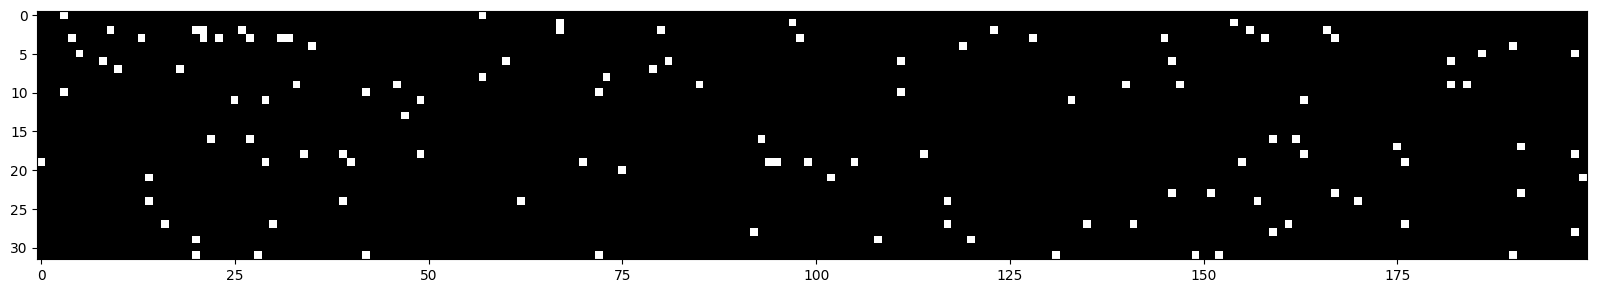

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap="gray",interpolation="nearest"); ###White means dead neurons//Because of the flat tail

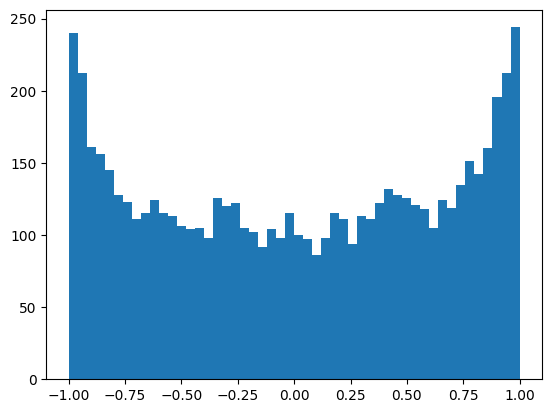

In [11]:
plt.hist(h.view(-1).tolist(),50);

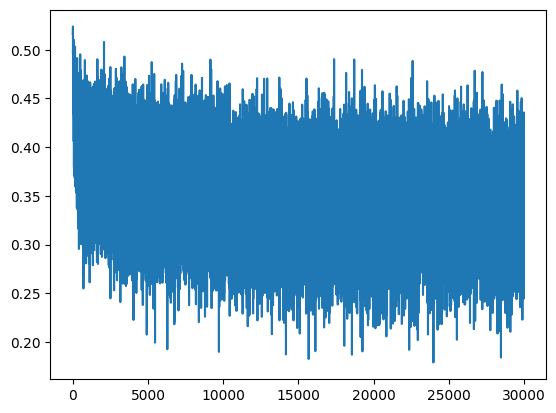

In [12]:
plt.plot(stepi,lossi)

In [13]:
#calibrate the batch norm statistic

with torch.no_grad() :
    emb=C[Xtr]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@W1 + b1
    #mesure the mean/std over the entre training set
    bnmean=hpreact.mean(0,keepdim=True)
    bnstd=hpreact.std(0,keepdim=True)


In [14]:
@torch.no_grad() #disable gradient tracking
def split_loss(split):
    dict={'train' : (Xtr,Ytr),
         'val' : (Xdev,Ydev),
         'test':(Xte,Yte),}
    x,y=dict[split]
    emb=C[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@W1 + b1
    hpreact=bngain*((hpreact-bnmean)/bnstd) + bnbias
    h=torch.tanh(hpreact) ##broadcasting
    logits=h@W2 +b2
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())



In [15]:
split_loss("val")

val 2.1870784759521484


In [25]:

from typing import Any


class Linear :
    def __init__(self,fan_in,fan_out,bias=True) -> None:
        self.weight=torch.randn((fan_in,fan_out),generator=g)/fan_in**0.5
        self.bias=torch.randn((fan_out)) if bias else None
    
    def __call__(self,x) -> Any:
        self.out=x@self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out

    def parameters(self) :
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1D :
    def __init__(self,dim,eps=1e-5, momentum=0.1 ) -> None:
        self.eps=eps
        self.dim=dim
        self.momentum=momentum
        self.is_training=True

        ##Scale and shift, learnable parameters using backprop
        self.gamma=torch.ones((self.dim))
        self.beta=torch.zeros((self.dim))

        ###Runnong mean and std
        self.running_mean=torch.zeros(dim)
        self.running_std=torch.ones(dim)
    
    def __call__(self,x) -> Any:
        if self.is_training :
             xmean=x.mean(0,keepdim=True)
             xvar=x.var(0,keepdim=True,unbiased=True)
        else :
            xmean=self.running_mean
            xvar=self.running_std
        
        xhat=(x-xmean)/torch.sqrt(xvar+self.eps) 
        self.out=self.gamma*xhat + self.beta

        if self.is_training :
            with torch.no_grad() :

                self.running_mean=(1-self.momentum)*xmean + self.momentum*xmean
                self.running_std=(1-self.momentum)*xvar + self.momentum*xvar

        return self.out
    
    def parameters(self):
        return [self.gamma,self.beta]
    


class Tanh:

    def __call__(self,x) -> None:
        self.out= torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
  


n_emb=10
n_hidden=100
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_emb),generator=g)

layers=[ Linear(n_emb*block_size,n_hidden),BatchNorm1D(n_hidden) ,Tanh(),
         Linear(n_hidden,n_hidden), BatchNorm1D(n_hidden),Tanh(), 
         Linear(n_hidden,n_hidden), BatchNorm1D(n_hidden),Tanh(), 
         Linear(n_hidden,n_hidden), BatchNorm1D(n_hidden),Tanh(), 
         Linear(n_hidden,n_hidden), BatchNorm1D(n_hidden),Tanh(), 
         Linear(n_hidden,n_hidden), BatchNorm1D(n_hidden),Tanh(), 
         Linear(n_hidden,vocab_size),BatchNorm1D(vocab_size),


]

with torch.no_grad() :
    #last layer make it less confident
    layers[-1].gamma*=0.1
    for layer in layers[:-1] :
        if isinstance(layer,Linear) :
            layer.weight*=5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters :
     p.requires_grad=True
            


In [26]:
batch_size=32
max_steps=30000
lossi=[]
ud=[]


for i in range(max_steps) :

    #mini batch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g )

    Xb,Yb=Xtr[ix],Ytr[ix]

    emb=C[Xb]
    H,W,CH=emb.shape

    #forward pass
    x=emb.view(H,W*CH)
    for layer in layers :
        x=layer(x)
    
  
    loss=F.cross_entropy(x,Yb)
    for p in parameters :
        p.grad=None
    loss.backward()

    ##update

    # lr=lrs[i]
    lr=0.1 if i< 10000 else  0.01
    for p in parameters :
        p.data+=-lr*p.grad
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    with torch.no_grad() :
    
            ud.append([((lr*p.grad.std())/p.data.std()).log10().item() for p in parameters])
    print(f"{i:7d}/{max_steps:7d} : {loss.item():4f}")

    if i>1000 :
        break
    

      0/  30000 : 3.293208
      1/  30000 : 3.283867
      2/  30000 : 3.300607
      3/  30000 : 3.275766
      4/  30000 : 3.273997
      5/  30000 : 3.276977
      6/  30000 : 3.249048
      7/  30000 : 3.266817
      8/  30000 : 3.254288
      9/  30000 : 3.236128
     10/  30000 : 3.235315
     11/  30000 : 3.247042
     12/  30000 : 3.244673
     13/  30000 : 3.215640
     14/  30000 : 3.210041
     15/  30000 : 3.225732
     16/  30000 : 3.211368
     17/  30000 : 3.190371
     18/  30000 : 3.216434
     19/  30000 : 3.156620
     20/  30000 : 3.252391
     21/  30000 : 3.125841
     22/  30000 : 3.211285
     23/  30000 : 3.140726
     24/  30000 : 3.160223
     25/  30000 : 3.170811
     26/  30000 : 3.224218
     27/  30000 : 3.154379
     28/  30000 : 3.170489
     29/  30000 : 3.196944
     30/  30000 : 3.127968
     31/  30000 : 3.113308
     32/  30000 : 3.143939
     33/  30000 : 3.094882
     34/  30000 : 3.198173
     35/  30000 : 3.143809
     36/  30000 : 3.159868
 

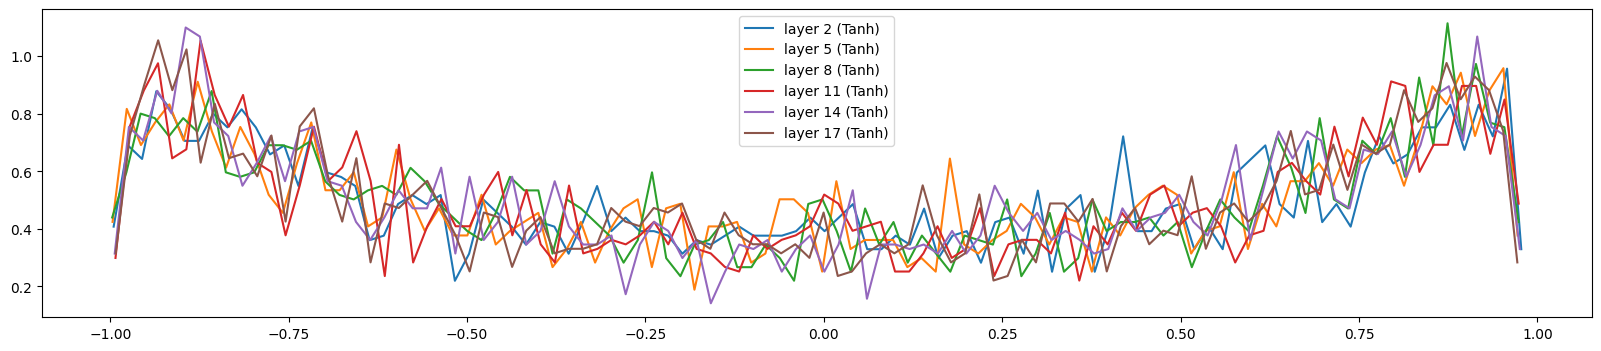

In [27]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]) :
    if isinstance(layer,Tanh):
        t=layer.out
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
    

None
None
None
None
None
None


c:\Users\Antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten\src\ATen/core/TensorBody.h:475.)
  return self._grad


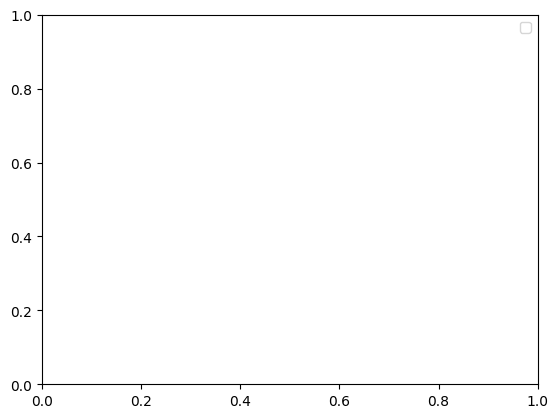

In [ ]:
legends=[]
for i,layer in enumerate(layers[:-1]) :
    if isinstance(layer,Tanh):
        t=layer.out.grad
        print(t)
        # hy,hx=torch.histogram(t.grad,density=True)
        # plt.plot(hx[:-1].detach(),hy.detach())
        # legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
    

ratio gradient: data   7.334285e-03
ratio gradient: data   2.098049e-02
ratio gradient: data   3.245583e-02
ratio gradient: data   2.655722e-02
ratio gradient: data   2.510882e-02
ratio gradient: data   2.500687e-02
ratio gradient: data   2.586728e-02
ratio gradient: data   4.781206e-02


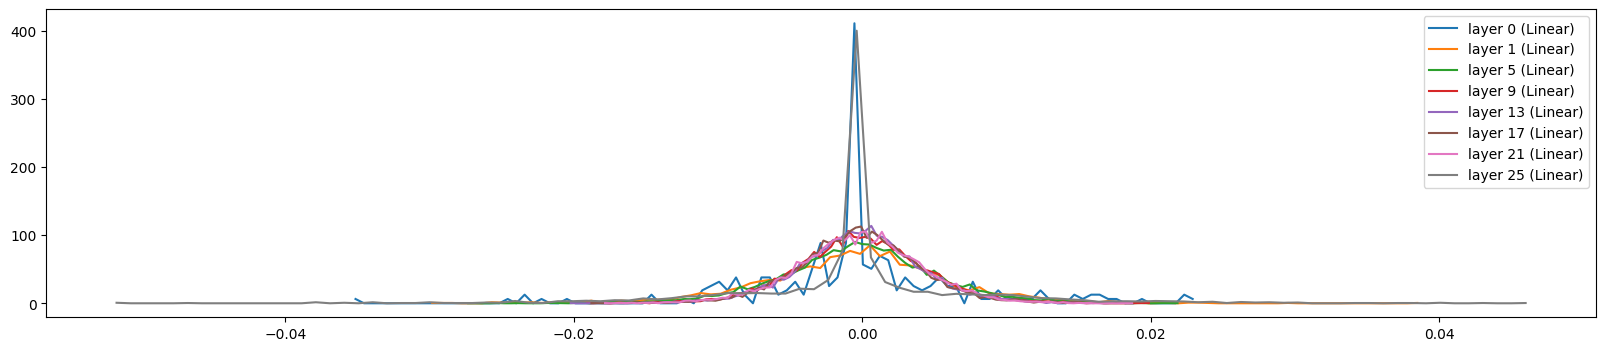

In [28]:
plt.figure(figsize=(20,4))
legends=[]
for i,p in enumerate(parameters) :
        t=p.grad
        if p.ndim==2 :
            hy,hx=torch.histogram(t,density=True)
            print("ratio gradient: data   %e" % (t.std()/p.data.std()) )
            plt.plot(hx[:-1].detach(),hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
    

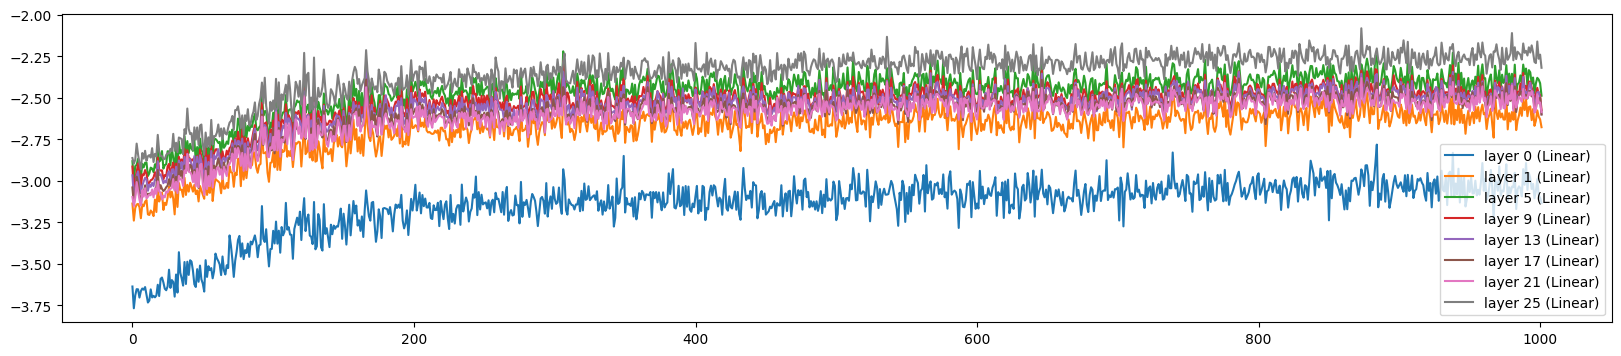

In [29]:
plt.figure(figsize=(20,4))
legends=[]
for i,p in enumerate(parameters) :
        t=p.grad
        if p.ndim==2 :
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)